### Whisper

important points:
```text
All audio is re-sampled to 16,000 Hz, and an 80-channel log-magnitude Mel spectrogram representation is computed on 25-millisecond windows with a stride of 10 milliseconds.

Whisper models are trained on 30-second audio chunks and cannot consume longer audio inputs at once

In [27]:
from typing import List, Dict, Optional
from torch import Tensor
import torch
import torchaudio
import os
from datasets import load_dataset

import sys
sys.path.append("/home/arunima/ASR/whisper")
import whisper
from whisper import DecodingOptions
from whisper.tokenizer import get_tokenizer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return [mel, text]
    

In [28]:
from whisper.tokenizer import get_tokenizer


dataset = LibriSpeech("test-clean")
# loader = torch.utils.data.DataLoader(dataset,batch_size=2)
loader = [dataset.__getitem__(i) for i in range(0,2)]

model = whisper.load_model("tiny")
language =  "english"
tokenizer = get_tokenizer(
            model.is_multilingual,
            num_languages=model.num_languages,
            language=language,
            task="transcribe",
        )

/home/arunima/ASR/whisper/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


ModelDimensions(n_mels=80, n_audio_ctx=1500, n_audio_state=384, n_audio_head=6, n_audio_layer=4, n_vocab=51865, n_text_ctx=448, n_text_state=384, n_text_head=6, n_text_layer=4)


In [49]:
from typing import Union
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

# Display the Log-Mel spectrogram
def display_logmel(mel):

    if mel.ndim == 3:
        mel = np.squeeze(mel)
    plt.figure(figsize=(10, 5))
    plt.imshow(mel, aspect="auto", origin="lower", cmap="magma")
    plt.colorbar(label="Log-Mel Spectrogram (dB)")
    plt.title("Whisper Log-Mel Spectrogram")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bands")
    plt.tight_layout()
    plt.show()


def plot_logits(data, suppression_len, perturbation_len):
    plt.figure(figsize=(10, 6))
    plt.plot(data.cpu().numpy(), label="loss Data")
    plt.title("Line Graph of loss with suppression length = "+str(suppression_len)+" and perturbation length = "+str(perturbation_len))
    plt.xlabel("Sequence indices with suppression length = "+str(suppression_len))
    plt.ylabel("Cross-entropy loss per sentence")
    plt.legend()
    plt.grid()
    plt.show()

def plot_logits_per_word(data,tokens, suppression_len):
    # Plot loss for each token index
    num_tokens = len(tokens)
    # Calculate number of rows and columns for subplots
    n_cols = 3  # You can adjust this number
    n_rows = (num_tokens + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
 
    for token_idx in range(num_tokens):
        plt.subplot(n_rows, n_cols, token_idx + 1)
        text_token = tokenizer.decode([tokens[token_idx]])
        plt.plot(data[:, token_idx].cpu().numpy(), 
                label=f"Token id:'{tokens[token_idx]},text: {text_token}'")
        plt.title(f"Cross-entropy Loss per Token (suppression={suppression_len})")
        plt.xlabel("Sequence Position")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
    
    
    plt.tight_layout()
    plt.show()

def create_suppression_dict(ind, suppresion_factor, perturbation_len):
    suppression_dict = {i: suppresion_factor for i in range(ind, ind + perturbation_len)}
    return suppression_dict
    


def collect_logits_per_sentence(mel_spec:Tensor, baseline_logits:Tensor, suppression_seq_len:int, suppression_factor:Union[List[int],int],perturbation_len:int=1500):

    loss_diff = torch.zeros(perturbation_len).to(DEVICE)

    for pos in range(perturbation_len):
        # Adjust perturbation length if it would exceed n_positions
        curr_perturbation_len = min(suppression_seq_len, perturbation_len - pos)
        
        suppression_dict = create_suppression_dict(pos, suppression_factor, curr_perturbation_len)
        options = DecodingOptions(fp16=False, language='english', perturbation=True, perturbation_tokens=suppression_dict)
        
        # Forward pass with perturbation
        decoded = model.decode(mel_spec, options)

        # print('pos=', pos, decoded.text)
        logits_perturbed = decoded.logits
        # print(logits_perturbed.shape,logits_perturbed[0].shape)
        perturbed_loss = torch.mean(torch.Tensor([F.cross_entropy(logit_per_token,
                                         F.softmax(baseline_logits[token_idx],dim=0), reduction='mean')for token_idx,logit_per_token in enumerate(logits_perturbed)]))

        # Compute loss difference
        loss_diff[pos] = perturbed_loss

    return loss_diff


def collect_logits_per_word(mel_spec:Tensor, baseline_logits:Tensor, suppression_seq_len:int, suppression_factor:Union[List[int],int],perturbation_len:int=1500):
    # Create tensor to store loss for each position and token index
    num_tokens = baseline_logits.shape[0]
    # token_texts = [model.tokenizer.decode([token]) for token in baseline_tokens]
    loss_diff = torch.zeros((perturbation_len, num_tokens)).to(DEVICE)

    for pos in range(perturbation_len):
        # Adjust perturbation length if it would exceed n_positions
        curr_perturbation_len = min(suppression_seq_len, perturbation_len - pos)
        
        suppression_dict = create_suppression_dict(pos, suppression_factor, curr_perturbation_len)
        options = DecodingOptions(fp16=False, language='english', perturbation=True, perturbation_tokens=suppression_dict)
        
        # Forward pass with perturbation
        decoded = model.decode(mel_spec, options)
        logits_perturbed = decoded.logits

        # Calculate loss for each token index
        for token_idx, logit_per_token in enumerate(logits_perturbed):
            loss = F.cross_entropy(logit_per_token,
                                 F.softmax(baseline_logits[token_idx],dim=0), 
                                 reduction='mean')
            loss_diff[pos, token_idx] = loss

    return loss_diff




In [ ]:
# for each sentence

flag = 0
for mel, target_text in tqdm(loader):
    print('Target text:', target_text)
    print('Mel shape:', mel.shape)
    display_logmel(mel.cpu().numpy())

    baseline_logits = model.decode(mel).logits
    print('baseline logits shape:',baseline_logits.shape)
    suppression_seq_len = 5
    suppression_factor = 0.5
    perturbation_len = model.dims.n_audio_ctx
    loss_diff = collect_logits_per_sentence(mel, baseline_logits, suppression_seq_len, suppression_factor, perturbation_len)
    
    plot_logits(loss_diff, suppression_seq_len, perturbation_len)
   # results = explain_whisper_tokens(model=model,mel=mels, tokens= target_tokens, suppression_dict = suppression_dict, prompt_explain_indices=prompt_explain_indices, max_batch_size=max_batch_size )
    break


  0%|          | 0/2 [00:00<?, ?it/s]

Target text: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE


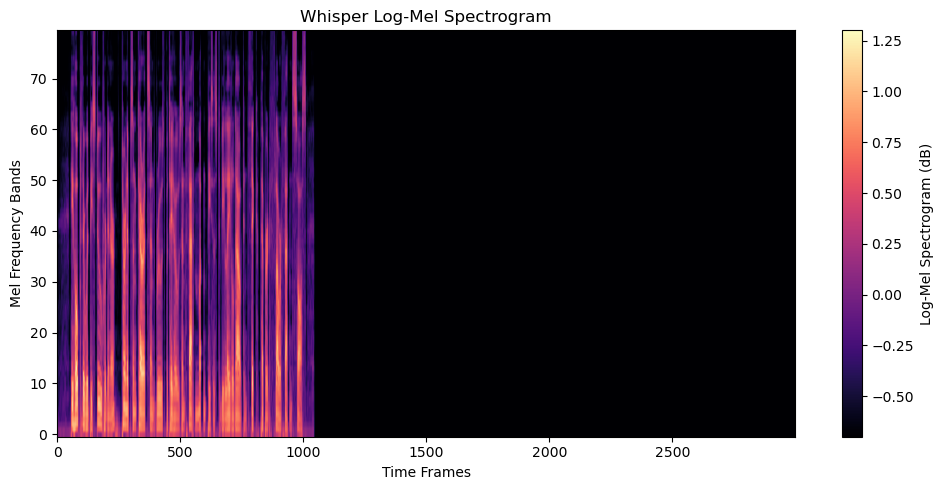

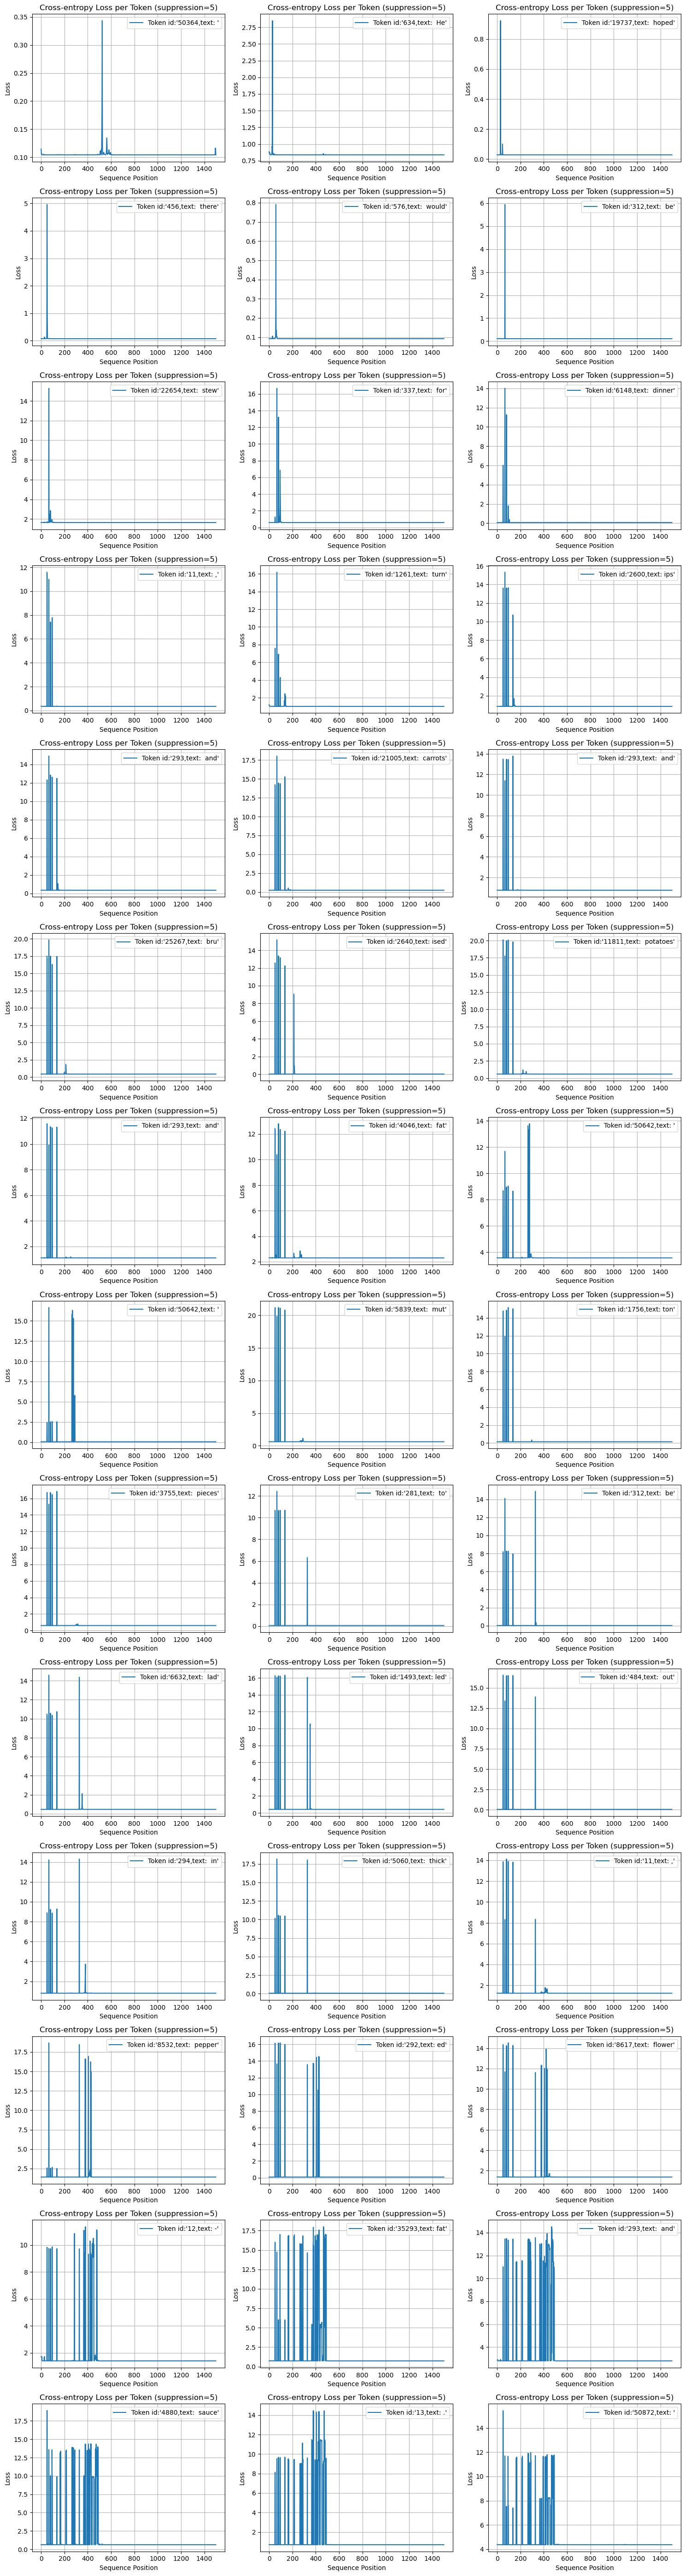

In [50]:
# for each word or token
flag = 0
for mel, target_text in tqdm(loader):
    print('Target text:', target_text)
    display_logmel(mel.cpu().numpy())
    decoded = model.decode(mel)

    baseline_logits = decoded.logits
    baseline_tokens = decoded.tokens
    # print('baseline token shape:',baseline_tokens)
    suppression_seq_len = 5
    suppression_factor = 0.5
    perturbation_len = model.dims.n_audio_ctx
    loss_diff = collect_logits_per_word(mel, baseline_logits, suppression_seq_len, suppression_factor, perturbation_len)
    
    plot_logits_per_word(loss_diff, baseline_tokens, suppression_seq_len)
   # results = explain_whisper_tokens(model=model,mel=mels, tokens= target_tokens, suppression_dict = suppression_dict, prompt_explain_indices=prompt_explain_indices, max_batch_size=max_batch_size )
    break

